In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import os

from torch.utils.data import Dataset

ID_TO_LABEL = {
    0: 'nilm', 1: 'ascus', 2: 'asch', 3: 'lsil', 
    4: 'hsil', 5: 'agc', 6: 't', 7: 'm', 8: 'bv'
}
LABEL_TO_ID = {v: k for k, v in ID_TO_LABEL.items()}

class C16Dataset(Dataset):
    def __init__(self, file_name, file_label, root, cluster_labels=None, persistence=False, transform=None):
        """
        参数
            file_name: WSI pt文件名列表
            file_label: WSI标签列表
            root: WSI pt文件根目录
            persistence: 是否将所有pt文件在init()中加载到内存中
            keep_same_psize: 是否保持每个样本的patch数量一致
            is_train: 是否为训练集
        """
        super(C16Dataset, self).__init__()
        self.file_name = file_name
        self.slide_label = file_label
        self.slide_label = [int(_l) for _l in self.slide_label]
        self.size = len(self.file_name)
        self.root = root
        self.persistence = persistence
        self.transform = transform
        self.cluster_labels = cluster_labels
        if persistence:
            self.feats = [torch.load(os.path.join(root, 'pt', _f + '.pt')) for _f in file_name]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        """
        Args
        :param idx: the index of item
        :return: image and its label
        """
        if self.persistence:
            features = self.feats[idx]
        else:
            if "pt" in os.listdir(self.root):
                dir_path = os.path.join(self.root, "pt")
            else:
                dir_path = self.root
            file_path = os.path.join(dir_path, self.file_name[idx] + '.pt')
            features = torch.load(file_path, map_location='cpu')
        
        label = int(self.slide_label[idx])
        
        # 为了让 Dataloader 正常工作，即使没有 transform 也返回 features 和 label
        # file_path 在这里不是必须的，但我们可以保留它
        # 注意：原始代码返回 file_path 可能导致默认的 collate_fn 出错，这里简化返回
        return features, label


# --- 你提供的代码 ---
train_label_path = '/data/wsi/TCTGC10k-labels/6_labels/TCTGC10k-v15-train.csv'
test_label_path = '/data/wsi/TCTGC10k-labels/6_labels/TCTGC10k-v15-test.csv'
dataroot = '/data/wsi/TCTGC50k-features/gigapath-coarse'

df_train = pd.read_csv(train_label_path)
df_test = pd.read_csv(test_label_path)

# --- 1. 合并训练集与测试集信息，用于整体EDA ---
print("Step 1: Preparing combined data for EDA...")
# 添加一个'set'列来区分数据来源
df_train['set'] = 'train'
df_test['set'] = 'test'
df_combined = pd.concat([df_train, df_test], ignore_index=True)

all_wsi_names = df_combined['wsi_name'].values
all_wsi_labels = df_combined['wsi_label'].map(LABEL_TO_ID).values
all_wsi_sets = df_combined['set'].values

print(f"Total slides for EDA: {len(df_combined)}")
print(f"Train slides: {len(df_train)}, Test slides: {len(df_test)}")

# --- 2. 创建Dataset和DataLoader ---
print("\nStep 2: Creating Dataset and DataLoader...")
# persistence=False 适用于特征数据量很大，无法一次性载入内存的情况
# DataLoader 会利用多线程(num_workers)在后台加载，效率很高
combined_dataset = C16Dataset(all_wsi_names, all_wsi_labels, dataroot, persistence=False)

# 使用 batch_size=1 来逐个处理WSI
# num_workers > 0 可以加速数据读取
dataloader = DataLoader(combined_dataset, batch_size=1, shuffle=False, num_workers=4)

# --- 3. 迭代DataLoader并进行平均池化 ---
print("\nStep 3: Aggregating features using mean pooling...")
slide_level_features = []
slide_level_labels = []

# 使用tqdm显示进度条
for features, label in tqdm(dataloader, desc="Processing slides"):
    # features 的形状是 [1, num_patches, feature_dim]
    # label 的形状是 [1]
    
    # a. 去掉batch维度
    features = features.squeeze(0)
    
    # b. 应用平均池化
    aggregated_feature = torch.mean(features, dim=0)
    
    # c. 收集结果
    slide_level_features.append(aggregated_feature)
    slide_level_labels.append(label.item())

# 将特征列表转换为一个大的Numpy数组
slide_features_np = torch.stack(slide_level_features).numpy()

print(f"Aggregation complete. Feature matrix shape: {slide_features_np.shape}")



Step 1: Preparing combined data for EDA...
Total slides for EDA: 10000
Train slides: 8000, Test slides: 2000

Step 2: Creating Dataset and DataLoader...

Step 3: Aggregating features using mean pooling...


Processing slides:   0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_19139/3022120874.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(file_p

Aggregation complete. Feature matrix shape: (10000, 1536)


In [ ]:
# --- 4. 使用UMAP降维 ---
print("\nStep 4: Performing dimensionality reduction with UMAP...")
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(slide_features_np)

print(f"UMAP embedding shape: {embedding.shape}")



Step 5: Visualizing the results...


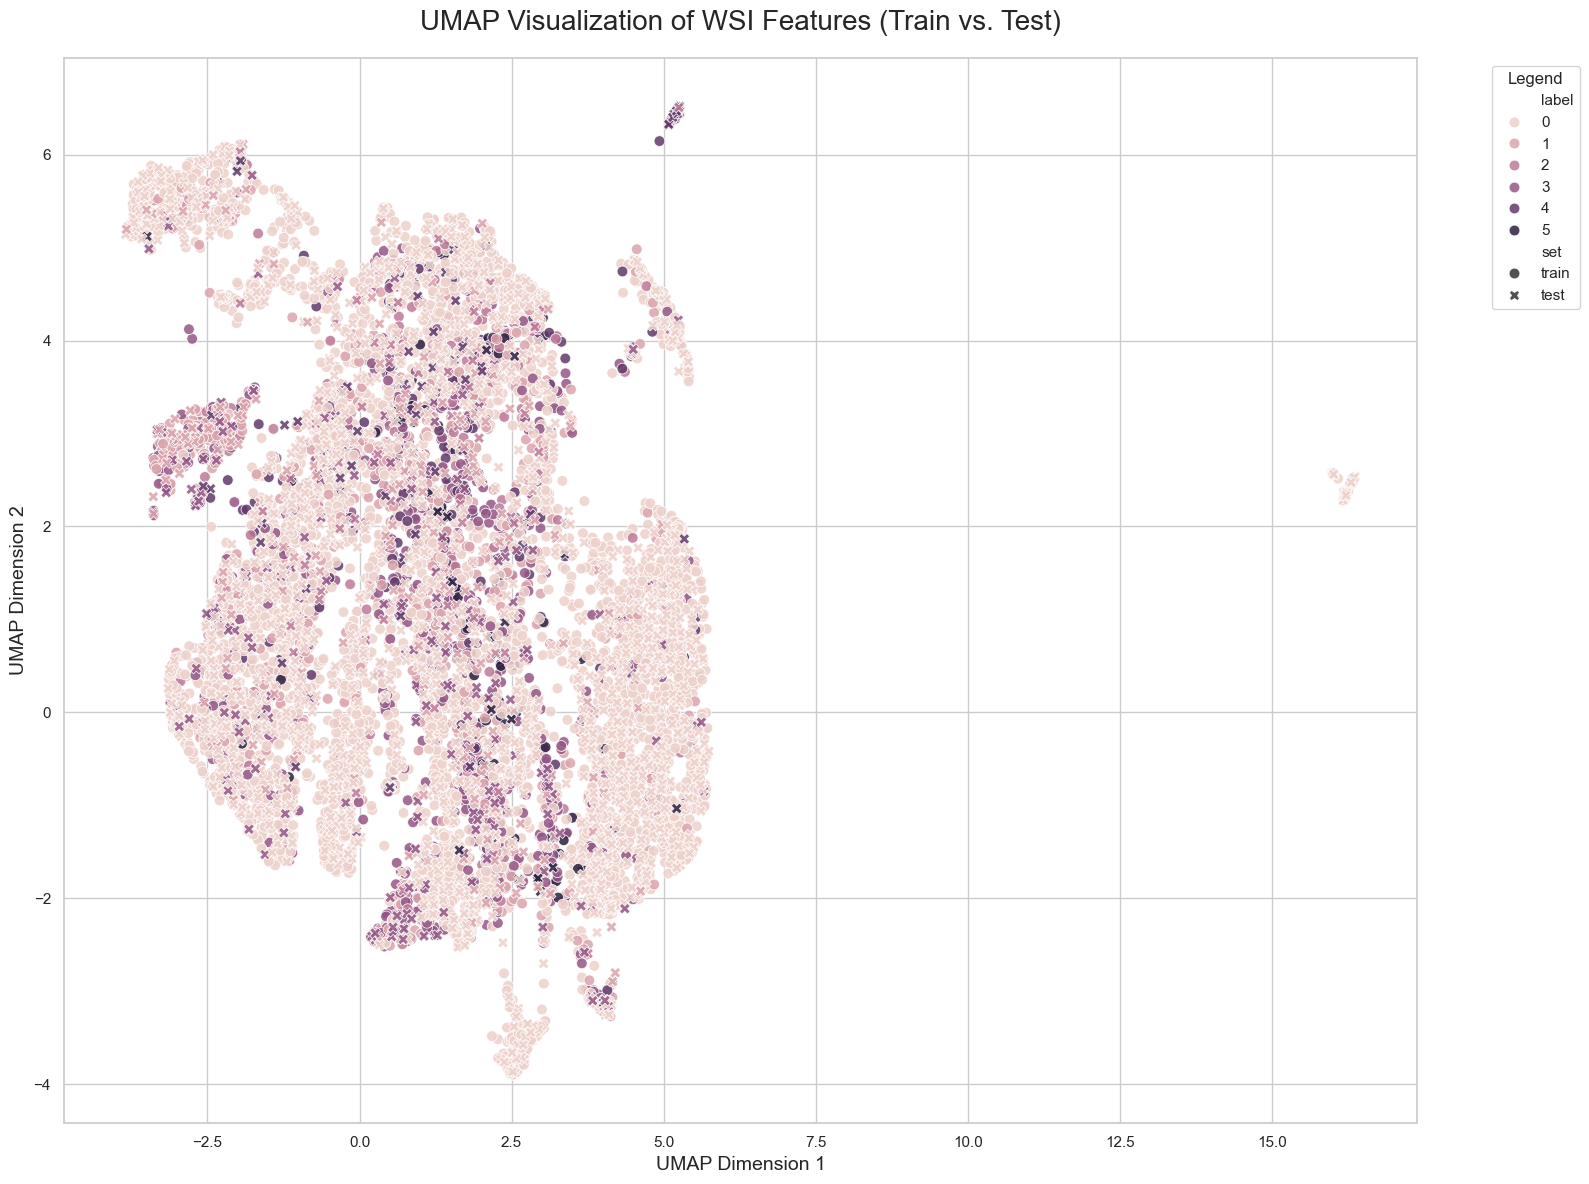

In [3]:
# --- 5. 可视化结果 ---
print("\nStep 5: Visualizing the results...")

# Create the final DataFrame for plotting (same as before)
vis_df = pd.DataFrame({
    'UMAP_1': embedding[:, 0],
    'UMAP_2': embedding[:, 1],
    'label': slide_level_labels,
    'set': all_wsi_sets, 
    'filename': all_wsi_names
})

# === BETTER APPROACH: Use sns.set_theme() ===
# This one line replaces plt.style.use() and sets the background, grid, and fonts.
sns.set_theme(style="whitegrid", palette="deep") 

# Now, create the plot
plt.figure(figsize=(16, 12))
sns.scatterplot(
    data=vis_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='label',
    style='set',
    # The palette is now set in set_theme(), so you can remove it from here
    s=60, 
    alpha=0.85
)

plt.title('UMAP Visualization of WSI Features (Train vs. Test)', fontsize=20, pad=20)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()